In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
import seaborn as sns
import pandas as pd
import numpy as np
import string
import re

In [13]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape, test.shape)

(7613, 5) (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Limpieza de la Columna Text

- Se elimina enlaces y espacios en blanco innecesarios
- Se crea columnas separadas que contengan listas de hashtags, menciones y enlaces.

In [3]:
def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Se elimina link
    text = re.sub(r'\n',' ', text) # Se elimina saltos de linea
    text = re.sub('\s+', ' ', text).strip() # Se eliminan espacios iniciales, finales y adicionales
    return text

def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))    
    return df

train_processed = train.copy()
test_processed = test.copy()
train_processed = process_text(train_processed)
test_processed = process_text(test_processed)

print(train_processed.shape, test_processed.shape)
print(train.shape, test.shape)

(7613, 9) (3263, 8)
(7613, 5) (3263, 4)


### Se crean estadisticas a partir de la Columna text

In [4]:
def crear_estadistica(df):
    # Longitud del Tweet
    df['text_len'] = df['text_clean'].apply(len)
    # Cantidad de Palabras
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Cantidad de Stopword
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Cantidad de Puntuaciones (.)
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Cantidad de Hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Cantidad de Menciones (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Cantidad de Links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Cantidad de letras Mayusculas
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Proporcion de letras Mayusculas
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

train_processed = crear_estadistica(train_processed)
test_processed = crear_estadistica(test_processed)

print(train_processed.shape, test_processed.shape)
print(train.shape, test.shape)

(7613, 18) (3263, 17)
(7613, 5) (3263, 4)


## Limpieza de la Columna Location

- Se une las localizaciones equivalentes
- Dejamos las localizaciones que estan en el Top 10 y es resto lo agrupamos en Others

In [6]:
# Fill NA values
raw_loc = train_processed.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)

for col in ['keyword','location']:
    train_processed[col] = train_processed[col].fillna('None')
    test_processed[col] = test_processed[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train_processed['location_clean'] = train_processed['location'].apply(lambda x: clean_loc(str(x)))
test_processed['location_clean'] = test_processed['location'].apply(lambda x: clean_loc(str(x)))

print(train_processed.shape, test_processed.shape)
print(train.shape, test.shape)

(7613, 19) (3263, 18)
(7613, 5) (3263, 4)


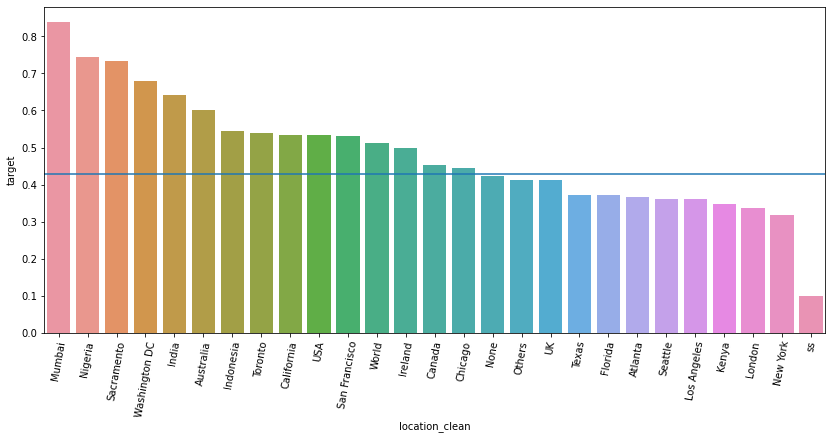

In [7]:
top_l2 = train_processed.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train_processed.target))
plt.xticks(rotation=80)
plt.show()

## Codificacion de variables categoricas

Como parte de la generacion de feactures haremos lo siguiente
- Aplicar target encoding para las columnas keyword y location

In [8]:
import category_encoders as ce

# Target encoding
features = ['keyword', 'location_clean']
encoder = ce.TargetEncoder(cols=features)
encoder.fit(train_processed[features],train_processed['target'])

train_processed = train_processed.join(encoder.transform(train_processed[features]).add_suffix('_target'))
test_processed = test_processed.join(encoder.transform(test_processed[features]).add_suffix('_target'))

print(train_processed.shape, test_processed.shape)
print(train.shape, test.shape)

(7613, 21) (3263, 20)
(7613, 5) (3263, 4)


## Bag of Words

- Se aplica countVectorizer el cual genera una columna por palabra y cuenta la frecuencia de cada palabra
- Se aplica Bag of Words a las columnas Links, Mentions, Hashtags 

In [9]:
# Only include those >=5 occurrences

# Links
vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+')
link_vec = vec_links.fit_transform(train_processed['links'])
link_vec_test = vec_links.transform(test_processed['links'])
X_train_link = pd.DataFrame(link_vec.toarray(), columns=vec_links.get_feature_names())
X_test_link = pd.DataFrame(link_vec_test.toarray(), columns=vec_links.get_feature_names())

# Mentions
vec_men = CountVectorizer(min_df = 5)
men_vec = vec_men.fit_transform(train_processed['mentions'])
men_vec_test = vec_men.transform(test_processed['mentions'])
X_train_men = pd.DataFrame(men_vec.toarray(), columns=vec_men.get_feature_names())
X_test_men = pd.DataFrame(men_vec_test.toarray(), columns=vec_men.get_feature_names())

# Hashtags
vec_hash = CountVectorizer(min_df = 5)
hash_vec = vec_hash.fit_transform(train_processed['hashtags'])
hash_vec_test = vec_hash.transform(test_processed['hashtags'])
X_train_hash = pd.DataFrame(hash_vec.toarray(), columns=vec_hash.get_feature_names())
X_test_hash = pd.DataFrame(hash_vec_test.toarray(), columns=vec_hash.get_feature_names())

train_bow = train_processed.join(X_train_link, rsuffix='_link')
train_bow = train_bow.join(X_train_men, rsuffix='_mention')
train_bow = train_bow.join(X_train_hash, rsuffix='_hashtag')

test_bow = test_processed.join(X_test_link, rsuffix='_link')
test_bow = test_bow.join(X_test_men, rsuffix='_mention')
test_bow = test_bow.join(X_test_hash, rsuffix='_hashtag')

print (train_bow.shape, test_bow.shape)
print(train_processed.shape, test_processed.shape)
print (train.shape, test.shape)

(7613, 152) (3263, 151)
(7613, 21) (3263, 20)
(7613, 5) (3263, 4)


### Se aplica TF-IDF a la columna Text

In [12]:
# Tf-idf for text

# Only include >=10 occurrences
# Have unigrams and bigrams
vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
text_vec = vec_text.fit_transform(train_processed['text_clean'])
text_vec_test = vec_text.transform(test_processed['text_clean'])
X_train_text = pd.DataFrame(text_vec.toarray(), columns=vec_text.get_feature_names())
X_test_text = pd.DataFrame(text_vec_test.toarray(), columns=vec_text.get_feature_names())

train_tf_idf = train.join(X_train_text, rsuffix='_text')
test_tf_idf = test.join(X_test_text, rsuffix='_text')

train_tf_idf_bow = train_bow.join(X_train_text, rsuffix='_text')
test_tf_idf_bow = test_bow.join(X_test_text, rsuffix='_text')

print (train_tf_idf_bow.shape, test_tf_idf_bow.shape)
print (train_tf_idf.shape, test_tf_idf.shape)
print (train_bow.shape, test_bow.shape)
print(train_processed.shape, test_processed.shape)
print (train.shape, test.shape)

(7613, 1843) (3263, 1842)
(7613, 1696) (3263, 1695)
(7613, 152) (3263, 151)
(7613, 21) (3263, 20)
(7613, 5) (3263, 4)


### Se guardan los datos

In [11]:
train_processed.to_csv('train_processed.csv')
test_processed.to_csv('test_processed.csv')

train_bow.to_csv('train_processed_bow.csv')
test_bow.to_csv('test_processed_bow.csv')

train_tf_idf.to_csv('train_processed_tf_idf.csv')
test_tf_idf.to_csv('test_processed_tf_idf.csv')

train_tf_idf_bow.to_csv('train_processed_tf_idf_bow.csv')
test_tf_idf_bow.to_csv('test_processed_tf_idf_bow.csv')